In [1]:
import os
import shutil

import pandas as pd
import requests
from sklearn.utils import Bunch
from tqdm.auto import tqdm

In [2]:
def get_data_dir():
    """Return the path of the scikit-uplift data dir.

    This folder is used by some large dataset loaders to avoid downloading the data several times.

    By default the data dir is set to a folder named ``scikit-uplift-data`` in the user home folder.

    Returns:
        string: The path to scikit-uplift data dir.

    """
    return os.path.join(os.path.expanduser("~"), "scikit-uplift-data")

In [3]:
def _create_data_dir(path):
    """Creates a directory, which stores the datasets.

    Args:
        path (str): The path to scikit-uplift data dir.

    """
    if not os.path.isdir(path):
        os.makedirs(path)

In [4]:
def _download(url, dest_path, content_length_header_key='Content-Length'):
    """Download the file from url and save it locally.

    Args:
        url (str): URL address, must be a string.
        dest_path (str): Destination of the file.
        content_length_header_key (str): The key in the HTTP response headers that lists the response size in bytes.
            Used for progress bar.
    """
    if isinstance(url, str):
        req = requests.get(url, stream=True)
        req.raise_for_status()

        with open(dest_path, "wb") as fd:
            total_size_in_bytes = int(req.headers.get(content_length_header_key, 0))
            progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
            for chunk in req.iter_content(chunk_size=2 ** 20):
                progress_bar.update(len(chunk))
                fd.write(chunk)
    else:
        raise TypeError("URL must be a string")

In [5]:
def _get_data(data_home, url, dest_subdir, dest_filename, download_if_missing,
              content_length_header_key='Content-Length'):
    """Return the path to the dataset.

    Args:
        data_home (str): The path to scikit-uplift data dir.
        url (str): The URL to the dataset.
        dest_subdir (str): The name of the folder in which the dataset is stored.
        dest_filename (str): The name of the dataset.
        download_if_missing (bool): If False, raise a IOError if the data is not locally available instead of
            trying to download the data from the source site.
        content_length_header_key (str): The key in the HTTP response headers that lists the response size in bytes.
            Used for progress bar.

    Returns:
        string: The path to the dataset.

    """
    if data_home is None:
        if dest_subdir is None:
            data_dir = get_data_dir()
        else:
            data_dir = os.path.join(get_data_dir(), dest_subdir)
    else:
        if dest_subdir is None:
            data_dir = os.path.abspath(data_home)
        else:
            data_dir = os.path.join(os.path.abspath(data_home), dest_subdir)

    _create_data_dir(data_dir)

    dest_path = os.path.join(data_dir, dest_filename)

    if not os.path.isfile(dest_path):
        if download_if_missing:
            _download(url, dest_path, content_length_header_key)
        else:
            raise IOError("Dataset missing")
    return dest_path

In [6]:
def clear_data_dir(path=None):
    """Delete all the content of the data home cache.

        Args:
            path (str): The path to scikit-uplift data dir

    """
    if path is None:
        path = get_data_dir()
    if os.path.isdir(path):
        shutil.rmtree(path, ignore_errors=True)

In [7]:
def fetch_dataset(target_col='conversion', data_home=None, dest_subdir=None, download_if_missing=True,
                    return_X_y_t=False):
    """Load and return dataset for promotion marketing campaig .
.
    Context
    
    Marketing Promotion Campaign
    with a total of 6,400 customers data.

    Content
    This dataset show customer's brief information,
    historical use of discount or BOGO(Buy One Get One) promotion,
    offer has been made, and the conversion result(buy or not).
    The conversion average value = $25
    
    Acknowledgements
    This dataset is a fictional dataset for practicing purpose

    Inspiration
    
    Predict customer's conversion rate
    Uplift Modelling to maximizing marketing campaign and reducing campaign cost

    Major columns:

    * ``conversion`` (binary): target. 1/0 indicator, 1 = Customer purchased merchandise in the following two weeks.
    * ``offer`` (str): treatment. The campaign the customer received (Discount/Buy One Get One/No Offer)

    Read more in the :ref:`docs <dataset>`.

    Args:
        target_col (string, 'visit' or 'conversion', 'spend' or 'all', default='visit'): Selects which column from dataset
            will be target
        data_home (str): The path to the folder where datasets are stored.
        dest_subdir (str): The name of the folder in which the dataset is stored.
        download_if_missing (bool): Download the data if not present. Raises an IOError if False and data is missing.
        return_X_y_t (bool, default=False): If True, returns (data, target, treatment) instead of a Bunch object.

    Returns:
        Bunch or tuple: dataset.

        Bunch:
            By default dictionary-like object, with the following attributes:

                * ``data`` (DataFrame object): Dataset without target and treatment.
                * ``target`` (Series or DataFrame object): Column target by values.
                * ``treatment`` (Series object): Column treatment by values.
                * ``DESCR`` (str): Description of the dataset.
                * ``feature_names`` (list): Names of the features.
                * ``target_name`` (str or list): Name of the target.
                * ``treatment_name`` (str): Name of the treatment.

        Tuple:
            tuple (data, target, treatment) if `return_X_y` is True

    References:
        https://www.kaggle.com/davinwijaya/customer-retention

    Example::

        from sklift.datasets import fetch_dataset


        dataset = fetch_dataset(target_col='conversion')
        data, target, treatment = dataset.data, dataset.target, dataset.treatment

        # alternative option
        data, target, treatment = fetch_dataset(target_col='conversion', return_X_y_t=True)

    See Also:

        :func:`.fetch_lenta`: Load and return the Lenta dataset (classification).

        :func:`.fetch_x5`: Load and return the X5 RetailHero dataset (classification).

        :func:`.fetch_criteo`: Load and return the Criteo Uplift Prediction Dataset (classification).

        :func:`.fetch_megafon`: Load and return the MegaFon Uplift Competition dataset (classification)
    """
    target_cols = ['offer', 'conversion']
    if target_col == 'all':
        target_col = target_cols
    elif target_col not in target_cols:
        raise ValueError(f"The target_col must be an element of {target_cols + ['all']}. "
                         f"Got value target_col={target_col}.")

    url = 'https://scikit-uplift-material.s3.eu-north-1.amazonaws.com/data.csv.zip'
    filename = url.split('/')[-1] 
    csv_path = _get_data(data_home=data_home, url=url, dest_subdir=dest_subdir,
                         dest_filename=filename,
                         download_if_missing=download_if_missing)

    treatment_col = 'offer'

    data = pd.read_csv(csv_path)
    treatment, target = data[treatment_col], data[target_col]

    data = data.drop(target_cols + [treatment_col], axis=1)

    if return_X_y_t:
        return data, target, treatment

    feature_names = list(data.columns)

    #module_path = os.path.dirname(os.path.abspath(__file__))
    #with open(os.path.join(module_path, 'descr', 'dataset.rst')) as rst_file:
        #fdescr = rst_file.read()

    return Bunch(data=data, target=target, treatment=treatment, #DESCR=fdescr,
                 feature_names=feature_names, target_name=target_col, treatment_name=treatment_col)

In [8]:
import sys
from matplotlib import pyplot as plt
from sklift.metrics import uplift_at_k
import seaborn as sns
import numpy as np
import pandas as pd
# install uplift library scikit-uplift and other libraries 
#!{sys.executable} -m pip install scikit-uplift dill catboost

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

## Load Dataset

We are going to use a dataset from the [Kaggle](https://www.kaggle.com/davinwijaya/customer-retention) created to practise and polish analytical skills in uplift modeling or churn prediction.

## Data description

Dataset can be loaded from sklift.datasets module using fetch_dataset function.

Read more about dataset in the [api docs](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_dataset.html).

This dataset contains 64,000 customers who purchased different goods. The customers were involved in a marketing campaign (buy one get one (BOGO), discount, other) 

**Major columns**

  - **conversion** (binary): target. 1/0 indicator, 1 = Customer purchased merchandise in the following two weeks.
  - **offer** (str): treatment. The campaign the customer received (Discount/Buy One Get One/No Offer)

In [9]:
dataset = fetch_dataset(target_col='conversion', data_home=None, dest_subdir=None, download_if_missing=True,
                    return_X_y_t=False)

In [10]:
print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

Dataset type: <class 'sklearn.utils.Bunch'>

Dataset features shape: (64000, 7)
Dataset target shape: (64000,)
Dataset treatment shape: (64000,)


## EDA 

In [11]:
dataset.data.head().append(dataset.data.tail())

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,10,142.44,1,0,Surburban,0,Phone
1,6,329.08,1,1,Rural,1,Web
2,7,180.65,0,1,Surburban,1,Web
3,9,675.83,1,0,Rural,1,Web
4,2,45.34,1,0,Urban,0,Web
63995,10,105.54,1,0,Urban,0,Web
63996,5,38.91,0,1,Urban,1,Phone
63997,6,29.99,1,0,Urban,1,Phone
63998,1,552.94,1,0,Surburban,1,Multichannel
63999,1,472.82,0,1,Surburban,0,Web


# Target & treatment data

In [12]:
#info about types and null cells in dataset
dataset.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 3.4+ MB


In [13]:
#transform categorical treatment data. 
dataset.treatment = dataset.treatment.replace(
    {'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0})

<AxesSubplot:>

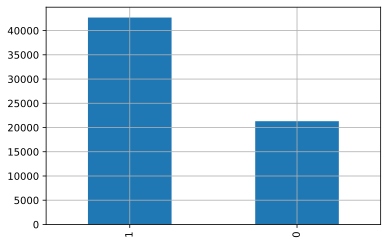

In [14]:
dataset.treatment.value_counts().plot(kind = 'bar', grid = 'True')

In [70]:
treatment

0        Buy One Get One
1               No Offer
2        Buy One Get One
3               Discount
4        Buy One Get One
              ...       
63995           Discount
63996           Discount
63997           Discount
63998    Buy One Get One
63999           Discount
Name: offer, Length: 64000, dtype: object

<AxesSubplot:>

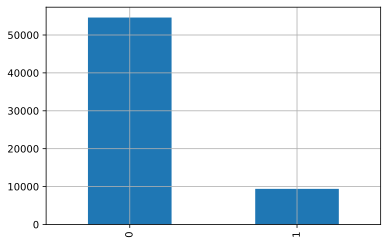

In [15]:
dataset.target.value_counts().plot(kind = 'bar', grid = 'True')

# Categorical and numeric data

<AxesSubplot:>

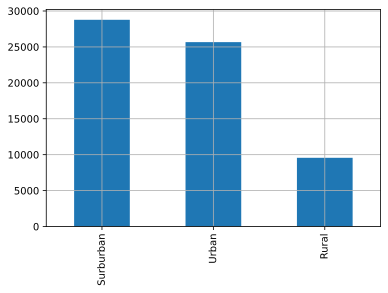

In [19]:
dataset.data.zip_code.value_counts().plot(kind = 'bar', grid=True)

<AxesSubplot:>

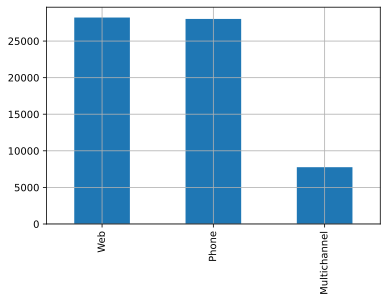

In [20]:
dataset.data.channel.value_counts().plot(kind = 'bar', grid=True)

<AxesSubplot:>

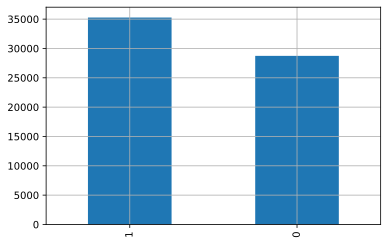

In [21]:
dataset.data.used_discount.value_counts().plot(kind = 'bar', grid=True)

<AxesSubplot:>

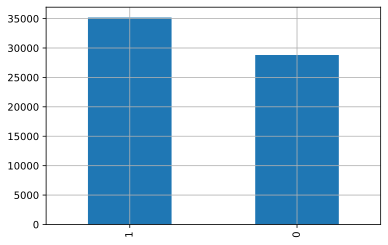

In [22]:
dataset.data.used_bogo.value_counts().plot(kind = 'bar', grid=True)

<AxesSubplot:>

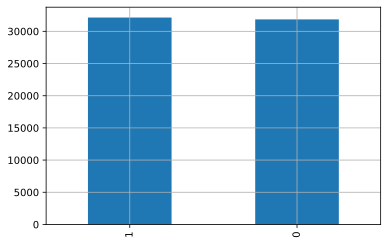

In [23]:
dataset.data.is_referral.value_counts().plot(kind = 'bar', grid=True)

<AxesSubplot:>

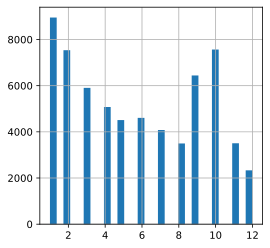

In [24]:
dataset.data.loc[:, 'recency'].hist(figsize=(4, 4), bins=30, grid=True)

<AxesSubplot:>

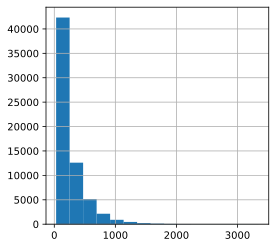

In [25]:
dataset.data.loc[:, 'history'].hist(figsize=(4, 4), bins=15, grid=True)

In [26]:
dataset.data['history_log'] = np.log(dataset.data['history'] + 1.1)

<AxesSubplot:>

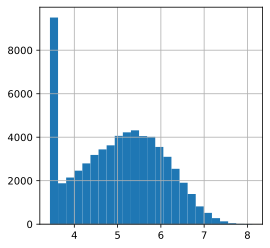

In [27]:
dataset.data.loc[:, 'history_log'].hist(figsize=(4, 4), bins=25, grid=True)

In [28]:
dataset.data.columns.to_list()

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'zip_code',
 'is_referral',
 'channel',
 'history_log']

In [30]:
#Let's replace history on history_log
features = ['recency', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel', 'history_log']

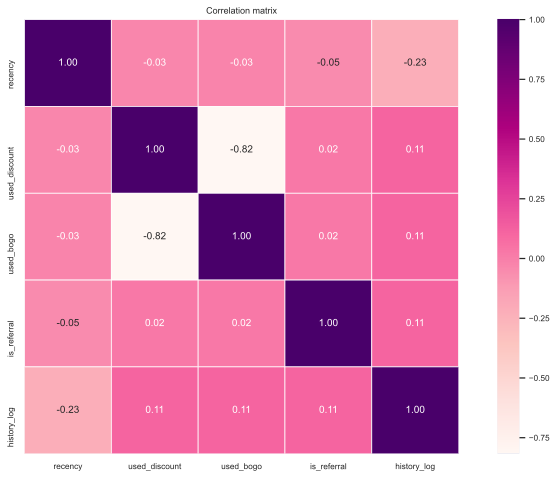

In [31]:
import seaborn as sns
plt.figure(figsize = (14,8))

sns.set(font_scale=0.75)
sns.heatmap(dataset.data[features].corr().round(3), annot=True, square = True, linewidths=.75, cmap='RdPu', fmt = '.2f',annot_kws = {"size": 10} )

plt.title('Correlation matrix')
plt.show()

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
#There is on gender feature in dataset. Let's take a look on indexes.

In [35]:
indices_learn, indices_valid = train_test_split(dataset.data.index, test_size=0.3, random_state=123)

In [36]:
train_features = dataset.data.copy()

In [39]:
dataset.target

0        0
1        0
2        0
3        0
4        0
        ..
63995    0
63996    0
63997    0
63998    0
63999    0
Name: conversion, Length: 64000, dtype: int64

In [40]:
X_train = train_features.loc[indices_learn, :]
y_train = dataset.target.loc[indices_learn]
treat_train = dataset.treatment.loc[indices_learn]

X_test = train_features.loc[indices_valid, :]
y_test = dataset.target.loc[indices_valid]
treat_test =  dataset.treatment.loc[indices_valid]

In [41]:
from sklift.models import ClassTransformation
from catboost import CatBoostClassifier

In [42]:
result_models = {
    'expirement_type': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [43]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': ['zip_code','channel']})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

result_models['expirement_type'].append('ClassTransformation')
result_models['uplift@10%'].append(ct_score_10)
result_models['uplift@20%'].append(ct_score_20)

<ipython-input-43-78fb7a7a5a56>:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': ['zip_code','channel']})


In [45]:
pd.DataFrame(data=result_models)

,expirement_type,uplift@10%,uplift@20%
0,ClassTransformation,0.108811,0.08994
